# Spatial Autocorrelation Analysis

I redo some of Spiro's work because matlab seems to like matrices of raw data, while I like to maintain meaningful labels on the row indices and column names. It helps me to keep my sanity and think more clearly about what the data represent as I manipulate and report them at each step.

## Loading and organizing data

In [1]:
import pandas as pd

expr_file = "../MA_resid.mat"
top_genes_file = "../136_genes.txt"

In [2]:
from scipy import io

""" Load the matlab file from disk. """

matlab_data = io.loadmat(expr_file, squeeze_me=True)

In [3]:
""" We need 1,777 cortical wellids in the same order as the expression data columns. """

column_labels = pd.DataFrame(matlab_data['dat'][1:], columns=matlab_data['dat'][0])['well_id']

In [4]:
""" We need 16,906 gene symbols in the same order as the expression data rows. """

# Some of the gene symbols have a trailing space, too, that needs to be stripped
row_labels = pd.DataFrame(matlab_data['gen'][1:], columns=matlab_data['gen'][0])['gene_symbol'].str.strip()

In [5]:
""" The expression data for Richiardi's selected gene list have had brain and batch_id regressed out
    and saved in the matlab file. It is assumed the order of genes is the same in the expression data
    and the labels. """

expr = pd.DataFrame(data=matlab_data['MA_resid'], columns=column_labels, index=row_labels)

## Calculate Moran's I for each gene

Our investigations over the last two years suggest that a threshold around 16 to 20 mm is at about the distance where proximity biases flatten out. For that reason, a continuous gradient up to 16mm is probably adequate for assessing Moran's I without hours of processing. We will report those "c16" data. But for curiosity, and to ensure we're not missing more distant effects, we will also extend our distance threshold out to 64mm, which will be computationally expensive, and should not change the results significantly. We also run binary weights, where all edges < threshold are set to 1 rather than graduated. This is probably pointless because we want to see the effect of the gradation in the space near each sample, but it may also accentuate any nonlinear clustering of gene expression with a plateau effect around the threshold.


In [6]:
from pysal.lib.weights import DistanceBand
from pysal.explore.esda.moran import Moran

samples = pd.DataFrame(matlab_data['dat'][1:], columns=matlab_data['dat'][0])
samples['geom'] = samples.apply(lambda row: (row['MNI_x'], row['MNI_y'], row['MNI_z']), axis=1)
loci = samples[['well_id', 'geom', ]].set_index('well_id')

weight_options = {}
for b in [True, False]:
    for d in [16, 64]:
        label = "b{}".format(d) if b else "c{}".format(d)
        weight_options[label] = DistanceBand.from_dataframe(loci, d, geom_col='geom', binary=b, silence_warnings=True)


In [7]:
""" Calculate and visually inspect a few values to see if our calculations match Spiro's.
    This can take a while... """

import os, datetime

moran_dfs = {}
for weight_label, weights in weight_options.items():
    start_time = datetime.datetime.now()
    print("Starting {} {}...".format(weight_label, start_time.strftime("on %B %d, %Y at %H:%M:%S")))
    
    csv_file = "./morans_{}.csv".format(weight_label)
    if os.path.isfile(csv_file):
        moran_dfs[weight_label] = pd.read_csv(csv_file).set_index('gene_symbol')
    else:
        moran_calcs = []
        for i in range(len(expr)):
            m = Moran(expr.iloc[i], weights, two_tailed=True)
            moran_calcs.append({
                'gene_symbol': expr.index[i],
                'I': m.I,
                'EI': m.EI,
                'p': m.p_norm,
            })
            # print("{}. {}: I = {:0.3f}, EI = {:0.5f}, p = {:0.5f}".format(i, expr.index[i], m.I, m.EI, m.p_norm))

        moran_dfs[weight_label] = pd.DataFrame(moran_calcs).set_index('gene_symbol')
        moran_dfs[weight_label].to_csv(csv_file)
        
    print("    ... completed {} {}".format(weight_label, datetime.datetime.now().strftime("on %B %d, %Y at %H:%M:%S")))
    print(moran_dfs[weight_label][:4])

Starting b16 on November 14, 2019 at 18:07:57...
    ... completed b16 on November 14, 2019 at 18:07:58
                    I        EI         p
gene_symbol                              
A1BG         0.001667 -0.000563  0.788571
A2M          0.068544 -0.000563  0.000000
NAT2        -0.005339 -0.000563  0.565828
SERPINA3     0.111641 -0.000563  0.000000
Starting b64 on November 14, 2019 at 18:07:58...
    ... completed b64 on November 14, 2019 at 18:07:58
                    I        EI         p
gene_symbol                              
A1BG         0.000639 -0.000563  0.338489
A2M          0.000386 -0.000563  0.449627
NAT2         0.002282 -0.000563  0.023498
SERPINA3     0.020750 -0.000563  0.000000
Starting c16 on November 14, 2019 at 18:07:58...
    ... completed c16 on November 14, 2019 at 18:07:58
                    I        EI         p
gene_symbol                              
A1BG         0.003984 -0.000563  0.651007
A2M          0.096887 -0.000563  0.000000
NAT2        -0.0

## Analyze the data

We are curious about whether Richiardi's 136 reported genes are different from all other genes, spatially speaking. In other words, did their spatial autocorrelation affect their ability to influence strength fraction in the context of inadequate proximity adjustment?

First, we ask what the Moran's I is for Richiardi's genes vs other genes.

In [8]:
""" Categorize genes. """

# Load Richiardi's list of 136 genes, stripping any whitespace from around their labels.
richiardi_genes = list(pd.read_csv(top_genes_file, header=None)[0].str.strip())
for morans in moran_dfs.values():
    morans['richiardi'] = pd.Series(morans.index, index=morans.index).isin(richiardi_genes)


In [9]:
""" Report quantitative values. """

import numpy as np

def report_morans(lbl, weight_label, df):
    print("{} genes {}({}): mean Moran's I = {:0.3f}, SD {:0.3f}, n = {:>6,}".format(
        lbl, " " * (13 - len(lbl)), weight_label, np.mean(df['I']), np.std(df['I']), len(df)
    ))
    
for weight_label, morans in moran_dfs.items():
    for a_slice in [
        ('All', morans),
        ('Non-Richiardi', morans[morans['richiardi'] == False]),
        ('Richiardi', morans[morans['richiardi']])
    ]:
        report_morans(a_slice[0], weight_label, a_slice[1])


All genes           (b16): mean Moran's I = 0.072, SD 0.093, n = 16,906
Non-Richiardi genes (b16): mean Moran's I = 0.070, SD 0.088, n = 16,770
Richiardi genes     (b16): mean Moran's I = 0.396, SD 0.134, n =    136
All genes           (b64): mean Moran's I = 0.021, SD 0.034, n = 16,906
Non-Richiardi genes (b64): mean Moran's I = 0.020, SD 0.032, n = 16,770
Richiardi genes     (b64): mean Moran's I = 0.145, SD 0.072, n =    136
All genes           (c16): mean Moran's I = 0.087, SD 0.105, n = 16,906
Non-Richiardi genes (c16): mean Moran's I = 0.084, SD 0.100, n = 16,770
Richiardi genes     (c16): mean Moran's I = 0.430, SD 0.142, n =    136
All genes           (c64): mean Moran's I = 0.032, SD 0.046, n = 16,906
Non-Richiardi genes (c64): mean Moran's I = 0.031, SD 0.043, n = 16,770
Richiardi genes     (c64): mean Moran's I = 0.201, SD 0.085, n =    136


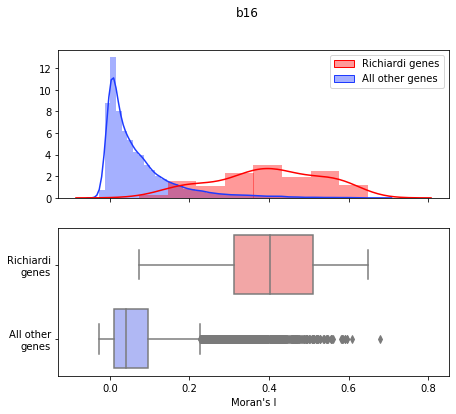

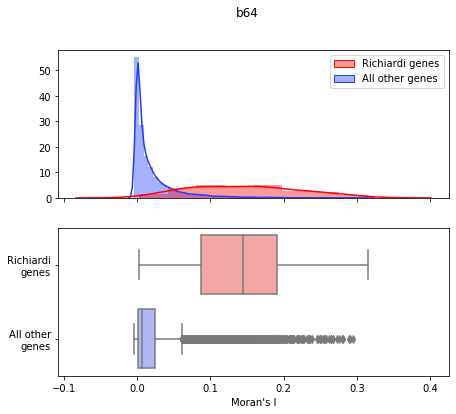

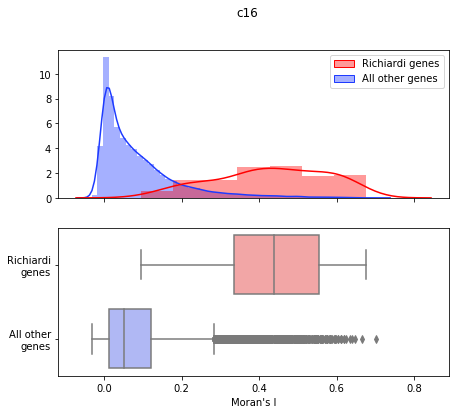

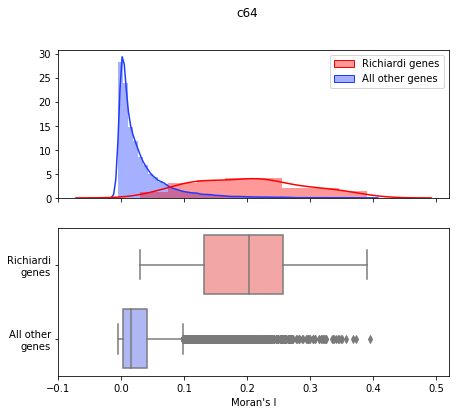

In [10]:
""" Plot the distribution, by inclusion in Richiardi's list. """

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

for weight_label, morans in moran_dfs.items():
    sns.set_palette(sns.color_palette(['#ff9999', '#a5b0ff']))
    fig, (ax_dist, ax_box) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7,6))
    
    sns.distplot(morans["I"], color="#1e3bff", ax=ax_dist)
    sns.distplot(morans[morans['richiardi']]["I"], color="red", ax=ax_dist)
    ax_dist.set_xlabel("")
    legend_elements = [
        Patch(facecolor='#ff9999', edgecolor='red', label='Richiardi genes'),
        Patch(facecolor='#a5b0ff', edgecolor='#1e3bff', label='All other genes'),
    ]
    ax_dist.legend(handles=legend_elements)
    
    sns.boxplot(x="I", y="richiardi", data=morans, orient="h", order=[True, False], ax=ax_box)
    ax_box.set_xlabel("Moran's I")
    ax_box.set_ylabel("")
    ax_box.set_yticklabels(["Richiardi\ngenes", "All other\ngenes"])
    
    # This can be changed to .tiff and dpi=300 for higher resolution images
    fig.suptitle(weight_label)
    fig.savefig("./moran_i_{}.png".format(weight_label), dpi=72, )

In [11]:
""" Report the quantitative results for report in the manuscript. """

df = moran_dfs["c16"]
for r in [True, False, ]:
    print("I {:0.4f} sd={:0.4f} p = {:0.9f}, (min p {:0.9f}, max p {:0.9f})".format(
        df[df["richiardi"] == r]["I"].mean(),
        df[df["richiardi"] == r]["I"].std(),
        df[df["richiardi"] == r]["p"].mean(),
        df[df["richiardi"] == r]["p"].min(),
        df[df["richiardi"] == r]["p"].max(),
    ))


I 0.4297 sd=0.1421 p = 0.000000000, (min p 0.000000000, max p 0.000000000)
I 0.0844 sd=0.0996 p = 0.146635404, (min p 0.000000000, max p 0.999837619)


----

Unnecessary exploratory code below this point

----

### An alternate way to get MNI coordinates directly from AHBA rather than the matlab file

In [12]:
""" This file contains all 3,702 wellids by 12 columns of data about them.
    Columns include MNI coordinates and fine and coarse names. """

import os
import pickle

PYGEST_DATA = "/data"
samples_file = os.path.join(PYGEST_DATA, "cache", "all-samples.df")

with open(samples_file, "rb") as f:
    ahba_samples = pickle.load(f)
ahba_samples.sample(3)

,structure_id,slab_num,slab_type,structure_acronym,structure_name,polygon_id,donor,vox_xyz,mni_xyz,coarse_name,fine_name,side
well_id,,,,,,,,,,,,
9197,9146,92,BS,LPB,"lateral parabrachial nucleus, left",1132188,H03512002,"(110, 116, 107)","(-17.3, -34.3, -28.4)",lateral parabrachial nucleus,lateral parabrachial nucleus,L
126432556,4178,8,CX,PLP,"planum polare, left",1407831,H03511012,"(142, 119, 97)","(-51.0, -6.0, -10.0)",planum polare,planum polare,L
11181,4087,6,CX,PoG-cs,"postcentral gyrus, left, bank of the central s...",1280014,H03511009,"(152, 71, 99)","(-61.0, -8.0, 38.0)",postcentral gyrus,"postcentral gyrus, bank of the central sulcus",L


### Manually view weights and distances supporting Moran's I calculations

In [13]:
""" Spot check one well_id's set of neighbors to ensure they are all within 16mm, as expected.
    And see how the weighting is implemented for each neighbor. """

import numpy as np

def dist(a, b):
    """ Calculate Euclidean distance between two points """
    a = np.array([float(x) for x in a])
    b = np.array([float(x) for x in b])
    return np.sqrt(np.sum((a - b)**2, axis=0))

maxl = 8  # Extent of any list to print - avoid ridiculous overprinting

# We are just sampling some data for manual review; keep it reasonable with "c16" rather than much longer "c64"
weights = weight_options["c16"]
print("1042 @ {}: {}".format(samples[samples['well_id'] == '1042']['geom'].values[0], weights.neighbors['1042'][:maxl]))
for weight in weights.neighbors['1042']:
    print("{:>4} @ {}: {} neighbors".format(
        weight,
        samples[samples['well_id'] == weight]['geom'].values[0],
        len(weights.neighbors[weight])
    ))
    print("       {}".format(weights.neighbors[weight][:maxl]))
    loci_of_neighbors = [samples[samples['well_id'] == x]['geom'].values[0] for x in weights.neighbors[weight]]
    locus_of_self = samples[samples['well_id'] == weight]['geom'].values[0]
    print("       {}".format(["{:0.1f}mm".format(dist(locus_of_self, b)) for b in loci_of_neighbors[:maxl]]))
    for w in sorted(list(weight_options.keys())):
        print("   {} {}".format(w, ["{:0.3f}".format(x) for x in weight_options[w].weights[weight][:maxl]]))


1042 @ ('58.800', '-22.900', '14.200'): ['956', '1035', '1027', '1034', '705', '713']
 956 @ ('58.100', '-9.700', '6.100'): 13 neighbors
       ['1042', '948', '770', '778', '938', '922', '877', '850']
       ['15.5mm', '7.8mm', '11.3mm', '9.7mm', '14.6mm', '13.4mm', '13.8mm', '11.6mm']
   b16 ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
   b64 ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
   c16 ['0.065', '0.129', '0.089', '0.103', '0.068', '0.075', '0.072', '0.086']
   c64 ['0.065', '0.129', '0.089', '0.103', '0.016', '0.016', '0.042', '0.040']
1035 @ ('69.300', '-24.900', '5.900'): 3 neighbors
       ['1042', '1027', '5148']
       ['13.5mm', '10.7mm', '15.2mm']
   b16 ['1.000', '1.000', '1.000']
   b64 ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
   c16 ['0.074', '0.093', '0.066']
   c64 ['0.074', '0.042', '0.053', '0.033', '0.041', '0.051', '0.045', '0.037']
1027 @ ('60.700', '-28.600', '0.700'): 8 

### Manually view dataframes

In [14]:
expr.iloc[0:4, 0:8]

well_id,1042,948,899,956,770,778,989,990
gene_symbol,,,,,,,,
A1BG,-0.462261,-0.173913,0.200101,-0.294910,0.270693,-0.134072,0.031156,-0.670598
A2M,0.382273,-0.075982,-0.352472,0.384405,-0.134426,-0.256347,-0.315110,0.399913
NAT2,-0.291798,-0.091831,-0.110132,-0.113791,0.338370,0.106912,-0.248555,-0.182311
SERPINA3,0.098576,-0.640421,0.141947,0.665134,-0.048537,-0.474026,0.528495,1.039238


In [15]:
for w in sorted(list(weight_options.keys())):
    print("Weights for {}: {:,}".format(w, weight_options[w].n))
    print("Moran I values for {}:".format(w))
    print(moran_dfs[w].iloc[0:4, :])
    print()

Weights for b16: 1,777
Moran I values for b16:
                    I        EI         p  richiardi
gene_symbol                                         
A1BG         0.001667 -0.000563  0.788571      False
A2M          0.068544 -0.000563  0.000000      False
NAT2        -0.005339 -0.000563  0.565828      False
SERPINA3     0.111641 -0.000563  0.000000      False

Weights for b64: 1,777
Moran I values for b64:
                    I        EI         p  richiardi
gene_symbol                                         
A1BG         0.000639 -0.000563  0.338489      False
A2M          0.000386 -0.000563  0.449627      False
NAT2         0.002282 -0.000563  0.023498      False
SERPINA3     0.020750 -0.000563  0.000000      False

Weights for c16: 1,777
Moran I values for c16:
                    I        EI         p  richiardi
gene_symbol                                         
A1BG         0.003984 -0.000563  0.651007      False
A2M          0.096887 -0.000563  0.000000      False
NAT2     

In [16]:
sorted(list(weight_options.keys()))


['b16', 'b64', 'c16', 'c64']

In [17]:
moran_dfs["c16"]["I"].mean()


0.08714896631404488

In [18]:
for i, row in moran_dfs["c16"][moran_dfs["c16"]["richiardi"] == True].iterrows():
    print("{} {:0.9f}".format(i, row.p))

ALOX12 0.000000000
ASGR2 0.000000000
CALB1 0.000000000
CD6 0.000000000
CD70 0.000000000
CDK1 0.000000000
COL5A2 0.000000000
CRYBA2 0.000000000
CYP2C18 0.000000000
GABRA5 0.000000000
GMPR 0.000000000
GNGT2 0.000000000
NPBWR2 0.000000000
GPR20 0.000000000
GPR26 0.000000000
GPX3 0.000000000
GRP 0.000000000
TLX2 0.000000000
HPCA 0.000000000
HOXD1 0.000000000
HPCAL1 0.000000000
HSD11B1 0.000000000
IL13RA2 0.000000000
KCNA1 0.000000000
KCNA3 0.000000000
KCNA5 0.000000000
KCNC1 0.000000000
KLK1 0.000000000
KRT1 0.000000000
KRT31 0.000000000
LAIR2 0.000000000
MGP 0.000000000
MYBPC1 0.000000000
MYH7 0.000000000
NEB 0.000000000
NEFH 0.000000000
NGFR 0.000000000
NOV 0.000000000
PCP4 0.000000000
PNMT 0.000000000
PTGS1 0.000000000
PVALB 0.000000000
RBP4 0.000000000
SCN1B 0.000000000
SCN4B 0.000000000
SLC20A2 0.000000000
SLN 0.000000000
SNAP25 0.000000000
TDO2 0.000000000
TGFBI 0.000000000
TSPAN8 0.000000000
TNNT2 0.000000000
GLRA3 0.000000000
FZD7 0.000000000
SEMA7A 0.000000000
NOL4 0.000000000
ADA